In [1]:
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from fastkde import fastkde
from sklearn.ensemble import RandomForestClassifier


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv('data/train.csv')

subset_size = int(len(train_data) / 10)
# subset the df to contain 10% of the data
train_data = train_data.sample(n=subset_size)

# split data into features and target
y = train_data['target']
x = train_data.drop(columns=['target','id'])

In [3]:
# run k-fold cross-validation
def cross_validate(kf,x,y,model):
    list_cm = []
    accuracy = []
    recall = []
    for train_index, test_index in kf.split(x,y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)

        accuracy.append(accuracy_score(y_test, y_pred))
        recall.append(recall_score(y_test,y_pred, average='binary'))
        list_cm.append(confusion_matrix(y_test,y_pred))
    # we return our confusion matrices, accuraciy values, and recall values for output
    return list_cm, accuracy, recall

Original Class Counts:
Class 0: 57325
Class 1: 2196

Proportion: 26.1 : 1


<Axes: title={'center': 'Counts for each class'}, xlabel='Class', ylabel='Count'>

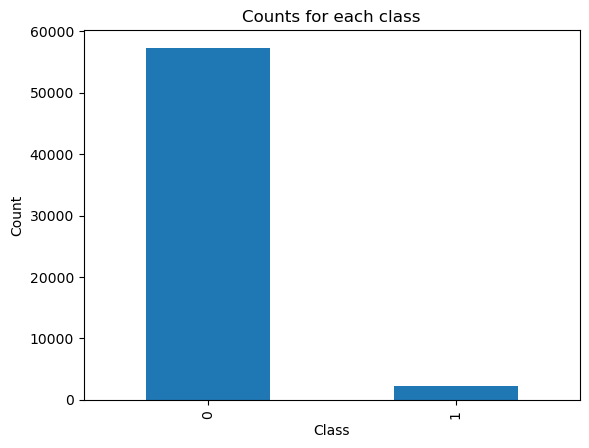

In [4]:
target_counts = y.value_counts()
print('Original Class Counts:')
print('Class 0:', target_counts[0])
print('Class 1:', target_counts[1])
print()
print('Proportion:', round(target_counts[0] / target_counts[1], 2), ': 1')

# plot the initial distribution of classes
target_counts.plot(kind='bar', title='Counts for each class', xlabel='Class', ylabel='Count')

### Synthetic Minority Oversampling (SMOTE)

In [5]:
oversample = SMOTE() # we use SMOTE to create an artificial oversample of the minority class
Xs, ys = oversample.fit_resample(x, y)
counter = Counter(ys)

In [6]:
model = KNeighborsClassifier() # we use k nearest neighbors to create clusters
SKFold = StratifiedKFold(n_splits=5)
scaler = StandardScaler()
Xs_scaled = scaler.fit_transform(Xs)
list_cm, accuracy, recall = cross_validate(SKFold, Xs_scaled, ys, model) #assign cm, accuracy, recall scores to the model

SMOTE Class Counts:
Class 0: 57325
Class 1: 57325

Proportion: 1.0 : 1


<Axes: title={'center': 'Class Counts Using SMOTE'}, xlabel='Class', ylabel='Count'>

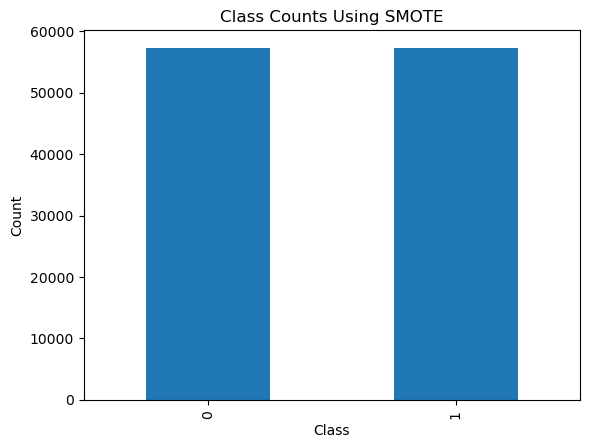

In [10]:
smote_counts = ys.value_counts()
print('SMOTE Class Counts:')
print('Class 0:', smote_counts[0])
print('Class 1:', smote_counts[1])
print()
print('Proportion:', round(smote_counts[0] / smote_counts[1], 3), ': 1')

# plot oversampled data
smote_counts.plot(kind='bar', title='Class Counts Using SMOTE', xlabel='Class', ylabel='Count')

In [18]:
# now we print the results
print(f"Accuracy: {np.mean(accuracy)}")
print(f"Recall: {np.mean(recall)}")
print(f"Confusion Matrix Average:\n {np.mean(list_cm, axis=0)}")

Accuracy: 0.8887658089838639
Recall: 0.9993720017444396
Confusion Matrix Average:
 [[8.92160e+03 2.54340e+03]
 [7.20000e+00 1.14578e+04]]


In [34]:
# results by fold
print(f"Fold 1 Confusion Matrix:\n {list_cm[0]}")
print(f"Fold 1 Accuracy: {accuracy[0]}")
print(f"Fold 1 Recall: {recall[0]}")
print()
print(f"Fold 2 Confusion Matrix:\n {list_cm[1]}")
print(f"Fold 2 Accuracy: {accuracy[1]}")
print(f"Fold 2 Recall: {recall[1]}")
print()
print(f"Fold 3 Confusion Matrix:\n {list_cm[2]}")
print(f"Fold 3 Accuracy: {accuracy[2]}")
print(f"Fold 3 Recall: {recall[2]}")
print()
print(f"Fold 4 Confusion Matrix:\n {list_cm[3]}")
print(f"Fold 4 Accuracy: {accuracy[3]}")
print(f"Fold 4 Recall: {recall[3]}")
print()
print(f"Fold 5 Confusion Matrix:\n {list_cm[4]}")
print(f"Fold 5 Accuracy: {accuracy[4]}")
print(f"Fold 5 Recall: {recall[4]}")

Fold 1 Confusion Matrix:
 [[ 8930  2535]
 [   36 11429]]
Fold 1 Accuracy: 0.8878761447884868
Fold 1 Recall: 0.996860008722198

Fold 2 Confusion Matrix:
 [[ 8953  2512]
 [    0 11465]]
Fold 2 Accuracy: 0.8904491931966856
Fold 2 Recall: 1.0

Fold 3 Confusion Matrix:
 [[ 8918  2547]
 [    0 11465]]
Fold 3 Accuracy: 0.8889228085477541
Fold 3 Recall: 1.0

Fold 4 Confusion Matrix:
 [[ 8897  2568]
 [    0 11465]]
Fold 4 Accuracy: 0.8880069777583951
Fold 4 Recall: 1.0

Fold 5 Confusion Matrix:
 [[ 8910  2555]
 [    0 11465]]
Fold 5 Accuracy: 0.8885739206279982
Fold 5 Recall: 1.0


### ADASYN with FastKDE

In [41]:
x_arr = np.array(x)
y_arr = np.array(y)

len(x_arr)
len(y_arr)

59521

In [42]:
x

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
151481,1,1,1,1,0,0,1,0,0,0,...,6,3,1,6,0,0,1,0,0,1
484164,0,1,2,1,0,1,0,0,0,0,...,8,1,1,7,0,0,0,0,0,0
320698,0,1,3,1,0,1,0,0,0,0,...,8,2,3,6,0,1,0,1,1,0
83505,2,1,7,1,2,0,1,0,0,0,...,6,2,4,6,0,1,1,0,1,1
594872,0,4,9,0,0,1,0,0,0,0,...,9,1,1,6,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343404,0,1,7,0,0,0,0,0,1,0,...,9,1,1,8,0,1,0,0,0,0
339838,0,2,8,1,0,0,0,0,1,0,...,6,1,1,11,0,1,0,0,0,0
367640,0,1,2,1,0,0,1,0,0,0,...,3,1,2,6,0,1,1,1,1,0
447201,1,1,10,0,0,1,0,0,0,0,...,8,1,2,6,0,0,0,0,0,0
